# Deep Water Bathymetric Particle Filter Experiment

This notebook runs the experiment testing the capabilities of the particle filter to conduct navigation using deep water bathymetry and for long duration.

## Data set preparation

First need to process the .m77t files in `source_data` into our database format. Additionally, we will create a 'truth' mechanization for the INS to serve as our ground truth reference comparison.

In [7]:
from src.data_management import m77t as tbx
import os
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from numpy import float64, int64, sin, cos, tan, rad2deg, deg2rad, eye
from matplotlib import pyplot as plt
from pyins import strapdown, transform, measurements, filters, sim, earth
from numpy.random import multivariate_normal as mvn
from src.geophysical import gmt_toolbox as gmt

In [8]:
from pygmt.datasets import (
    load_earth_relief,
    load_earth_free_air_anomaly,
    load_earth_magnetic_anomaly,
)

In [9]:
relief = gmt.GeophysicalMap(gmt.MeasurementType.RELIEF, gmt.ReliefResolution.ONE_MINUTE, -1, 1, -1, 1)

In [10]:
relief.get_map_point(0, 0)

array(-3128.5)

## Truth Mechanization

The truth mechanization will be a simple INS mechanization from the simulated trajectory values. This will be used to compare the performance of the particle filter.

In [22]:
home = os.path.join("~/Code/research_workspace")
datapath = os.path.join(home, "source_data", "marine_tracklines")
outpath = os.path.join(home, "source_data", "db")

datain = tbx.process_m77t_file(os.path.join("test", "test_data.m77t"))
traj = datain[0].copy()
traj_ins = traj.copy()
traj_ins.index = traj.index.to_series().diff().dt.total_seconds().fillna(0).cumsum()

increments = strapdown.compute_increments_from_imu(traj_ins, "rate")
observations = measurements.Position(sim.generate_position_measurements(traj_ins[["lat", "lon", "alt"]], 5.0), 5.0)
init_pva = traj_ins.loc[
    traj_ins.index[0],
    ["lat", "lon", "alt", "VN", "VE", "VD", "roll", "pitch", "heading"],
]
distance = traj_ins["distance"].to_numpy()

In [12]:
# Run the mechanization
feedback = filters.run_feedback_filter(
    init_pva,
    5,
    2,
    1,
    1,
    increments,
    measurements=[observations],
    time_step=1.0,
    with_altitude=True,
)
errors = transform.compute_state_difference(traj_ins, feedback.trajectory)

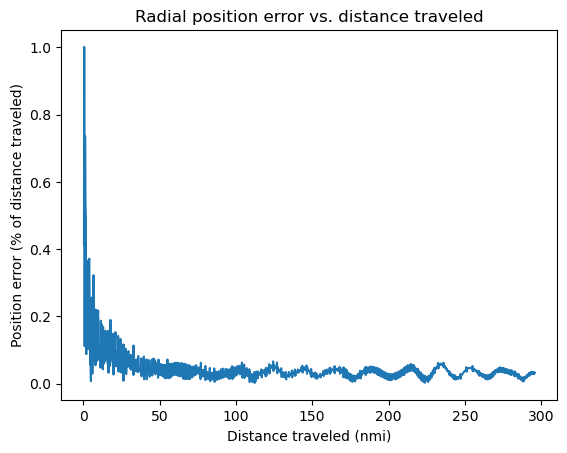

In [13]:
# Plot the results as a function of distance traveled
plt.plot(
    distance / 1852,
    100 * np.sqrt(errors.north**2 + errors.east**2) / distance,
    label="radial",
)
plt.xlabel("Distance traveled (nmi)")
plt.ylabel("Position error (% of distance traveled)")
plt.title("Radial position error vs. distance traveled")
plt.show()

## Particle Filter Mechanization

The particle filter mechanization will be a simple INS mechanization from the simulated trajectory values. This will be used to compare the performance of the particle filter.

In [19]:
import numpy as np
from src.geophysical import particle_filter as pf
from src.geophysical import gmt_toolbox as gmt
from pyins.strapdown import Integrator

In [15]:
pfconfig = pf.ParticleFilterConfig.from_dict(
    {
        "n": 100,
        "cov": np.arange(18),
        "noise": np.arange(18),
        "measurement_config": [
            {"name": "bathymetry", "std": 15},
            {"name": "gravity", "std": 1},
            {"name": "magnetic", "std": 5},
        ],
    }
)

In [23]:
integrator = Integrator(init_pva, True)

In [ ]:
import time

for n in [1000, 10000, 25000, 50000, 100000, 250000, 500000]:
    start = time.time()
    for i in range(n):
        integrator.predict(increments.iloc[1])
    end = time.time()
    print(f"For n={n:d}, time elapsed: {end-start:.2f} s")

For n=1000, time elapsed: 0.99 s
For n=10000, time elapsed: 9.36 s
For n=25000, time elapsed: 23.23 s
For n=50000, time elapsed: 47.21 s
For n=100000, time elapsed: 101.00 s


### Some notes

The numba jitting causes some issues with using other methods that have not been jitted. The PyINS packages is very much designed around a pandas data frame to manage data and not neccessarily done in a way that is particularly flexible. At this point I think it would be best to recreate PyINS in C++ designed to be a toolbox rather than a prescribed simulator and include my particle filter implementation in that toolbox.

# Particle filter propagation testing

In [13]:
from numpy import cross, array, float64, int64
from numpy.typing import NDArray
import numpy as np
from pyins import earth, transform
from scipy.spatial.transform import Rotation as R
from numba import njit, jit
from numpy.random import multivariate_normal as mvn

EARTH_RATE = earth.RATE

In [25]:
def propagate_ned(
    particles: NDArray[float64 | int64],
    gyros: NDArray[float64 | int64],
    accels: NDArray[float64 | int64],
    dt: float64 | int64,
) -> NDArray:
    """
    Propagate the particles according to the strapdown INS equations using only
    NumPy operations and a more Pythonic syntax.
    """
    # Getting some constants
    Rn, Re, _ = earth.principal_radii(particles[:, 0], particles[:, 2])
    gravity_vector = earth.gravity_n(particles[:, 0], particles[:, 2])
    # Prior values
    lat_ = deg2rad(particles[:, 0])
    lon_ = deg2rad(particles[:, 1])
    alt_ = particles[:, 2]
    vn_ = particles[:, 3]
    ve_ = particles[:, 4]
    vd_ = particles[:, 5]
    C_ = transform.mat_from_rph(deg2rad(particles[:, 6:9]))

    # Attitude update
    Omega_ies = array(
        [earth.RATE * vector_to_skew_symmetric([cos(particle[0]), 0, -sin(particle[1])]) for particle in particles]
    )
    omegas = array([ve_ / (Re + alt_), -vn_ / (Rn + alt_), -ve_ * tan(lat_) / (Re + alt_)]).T
    Omega_ens = array([vector_to_skew_symmetric(omega) for omega in omegas])
    Omega_ibs = array([vector_to_skew_symmetric(gyros - particle[9:12]) for particle in particles])

    C = C_ @ (eye(3) + Omega_ibs * dt) - (Omega_ies + Omega_ens) @ C_ * dt

    # Specific force transformation
    f = 0.5 * (C + C_) @ accels

    # Velocity update
    q = Omega_ens + 2 * Omega_ies
    velocity = (
        particles[:, 3:6]
        + (f - particles[:, 9:12] + gravity_vector - array([q_ @ v for q_, v in zip(q, particles[:, 3:6])])) * dt
    )

    # Position Update
    alt = particles[:, 2] - dt / 2 * (particles[:, 6] + particles[:, 3:6][:, 2])
    lat = rad2deg(lat_ + dt / 2 * (vn_ / (Rn + lat_) + velocity[:, 0] / (Rn + alt)))
    lon = rad2deg(lon_ + dt / 2 * (ve_ / ((Re + alt_) * cos(lat_)) + velocity[:, 1] / ((Re + alt) * cos(lat))))
    rph = rad2deg(transform.mat_to_rph(C))
    # Gyro and accel bias update
    # gyro_bias = particles[:, 9:12] + mvn([0, 0, 0], noise[9:12], n)
    # accel_bias = particles[:, 12:15] + mvn([0, 0, 0], noise[12:15], n)
    return np.column_stack([lat, lon, alt, velocity, rph])

In [18]:
traj.head()

,lat,lon,alt,VN,VE,VD,roll,pitch,heading,gyro_x,...,gyro_z,accel_x,accel_y,accel_z,distance,depth,gra_obs,freeair,mag_tot,mag_res
1973-04-26 04:07:00+00:00,37.50166,-74.21333,0.0,3.213706,5.694073,-0.016507,0.0,0.0,71.529557,0.000018,...,-0.000045,0.077385,0.031718,-9.797804,0.000000,1157.0,NaN,NaN,NaN,NaN
1973-04-26 04:08:00+00:00,37.50333,-74.20833,0.0,3.024583,8.205587,0.005291,0.0,0.0,71.529557,0.000019,...,-0.000569,-0.000056,-0.000715,-9.798631,957.123809,1148.0,NaN,NaN,NaN,NaN
1973-04-26 04:09:00+00:00,37.50500,-74.20333,0.0,3.222808,5.694371,-0.004656,0.0,0.0,68.853811,0.000019,...,-0.000287,-0.075672,-0.037144,-9.798865,1304.044785,1144.0,NaN,NaN,NaN,NaN
1973-04-26 04:10:00+00:00,37.50666,-74.20000,0.0,2.556624,5.842633,0.004333,0.0,0.0,69.522747,0.000021,...,-0.000306,0.072670,0.057910,-9.798882,1782.584011,1146.0,NaN,NaN,NaN,NaN
1973-04-26 04:11:00+00:00,37.50833,-74.19500,0.0,5.037773,7.765765,-0.002676,0.0,0.0,66.885130,0.000021,...,-0.000478,0.021667,-0.113569,-9.798489,2358.440619,970.0,NaN,NaN,NaN,NaN


In [ ]:
# Initialization parameters
n = 100
dt = 60
i = 10
mu = traj.iloc[i][["lat", "lon", "alt", "VN", "VE", "VD", "roll", "pitch", "heading"]].to_numpy()
mu = np.hstack((mu, np.zeros(6)))
noise = np.array(
    [
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.1,
        0.01,
        0.01,
        0.01,
        0.001,
        0.001,
        0.001,
        0.001,
        0.001,
        0.001,
    ]
)
particles = mvn(mu, np.eye(15), n)

# Coning and sculling with conversions doesn't work (is unneeded) for the PF
# thetas, dvs = coning_and_sculling_correction(current_gyros, previous_gyros, current_accels, previous_accels)

# Getting starting values and inputs
gyros = traj.iloc[i][["gyro_x", "gyro_y", "gyro_z"]].to_numpy()  # * dt
accels = traj.iloc[i][["accel_x", "accel_y", "accel_z"]].to_numpy()

propagate_ned(particles, gyros, accels, dt)

# Numba playground

So after doing some research and experimentation I've found two things:

1. Numba functions can only call other jitted functions, not Python functions. So if `foo` is a jitted function that calls `bar`, `bar` must also be a jitted function.
2. Numba really only works well with the foreknowledge that the data is going to be a certain type (numpy array) and known size. Functions like `squeeze` and calls to the `ndarray` class are not supported.

A couple of thoughts and options here:

* Write public wrapper functions that do all the input validations and then call a private jitted function.
* Make use of type annotations and documentation to make it clear what the expected input is. If it breaks that's on the user.

So: for the particle filter implementation, I think I need to go with 

## Simulation parameters verification

First we need to tune the particle filter propagation noise to be similar to that of a marine-grade inertial navigation system. A low-end marine-grade INS should have a drift of 1 nm per 24 hours.

In [ ]:
from src.particle_filter import rmse, propagate
import numpy as np

time = 24 * 60  # minutes
noise = np.array([0, 2.6, 0])
bound = 1852  # meters

errors = []
for v in range(1, 26):
    P = np.asarray([[0, 0, 0, 0, v, 0]])
    T = P.copy()
    t = 0
    for i in range(50000):
        # Eastward
        u = [0, v, 0]
        while t < time:
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0, 0, 0]), noise_calibration_mode=False)
            t += 1
        errors.append(rmse(P, T[0, :2]))
        # Northward
        u = [v, 0, 0]
        while t < time:
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0, 0, 0]), noise_calibration_mode=False)
            t += 1
        errors.append(rmse(P, T[0, :2]))
        # Northeastward
        u = np.array([1, 1, 0]) / np.linalg.norm([1, 1, 0])
        u *= v
        while t < time:
            P = propagate(P, u, noise=np.diag(noise), noise_calibration_mode=True)
            T = propagate(T, u, noise=np.diag([0, 0, 0]), noise_calibration_mode=False)
            t += 1
        errors.append(rmse(P, T[0, :2]))

print(f"RMSE: {np.mean(errors)}")

In [ ]:
from matplotlib import pyplot as plt

if not os.path.exists(".db/plots"):
    os.makedirs(".db/plots")

plt.hist(errors, bins=15, density=True)
plt.xlabel("RMSE (m)")
plt.ylabel("Frequency")
plt.title("RMSE of Particle Filter")
plt.savefig(".db/plots/propagation_tuning.png")
plt.show()

In [ ]:
config = {"velocity_noise": [noise[1], noise[1], 0]}

## Develop measurement model

Next we need to develop the measurement value standard deviation. We'll first do some general examination of the data. Namely, investigating the sensor measurements to see if we can build a reasonable sensor model.

In [ ]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import numpy as np
import json

if os.path.exists("config.json"):
    config = json.load(open("config.json", "r"))

tables = pdset.get_tables(".db/parsed.db")
bathy_tables = [table for table in tables if "_D_" in table]

d_bathy = np.array([])

for table in bathy_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    bathy_map = get_map_section(min_lon, max_lon, min_lat, max_lat, "relief", "15s", "temp")
    d_bathy = np.hstack([d_bathy, data["DEPTH"] - (-get_map_point(bathy_map, data.LON, data.LAT))])

config["bathy_mean_d"] = np.mean(d_bathy, where=~np.isnan(d_bathy))
config["bathy_std"] = np.std(d_bathy, where=~np.isnan(d_bathy))

if os.path.exists("config.json"):
    # delete the file
    os.remove("config.json")

with open("config.json", "w") as f:
    json.dump(config, f)

In [ ]:
plt.hist(d_bathy, bins=200, density=True)
plt.xlim([-300, 300])
plt.xlabel("Depth Difference (m)")
plt.ylabel("Frequency")
plt.title("Bathymetry Difference")
plt.savefig(".db/plots/bathy_diff.png")
plt.show()

In [ ]:
config

In [ ]:
import json

with open("config.json", "w") as f:
    json.dump(config, f)

### Populate with velocities

In [ ]:
from src.particle_filter import (
    process_particle_filter,
    populate_velocities,
    plot_error,
    plot_estimate,
    summarize_results,
)
import json
import src.process_dataset as pdset
from tqdm import tqdm
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
tables = pdset.get_tables(".db/parsed.db")
bathy_tables = [table for table in tables if "_D_" in table]
config = json.load(open("config.json", "r"))
config["n"] = 1000
config["cov"] = [
    1 / 60,
    1 / 60,
    0,
    config["velocity_noise"][0],
    config["velocity_noise"][1],
    0,
]

with open("config.json", "w") as f:
    json.dump(config, f)

In [ ]:
config

In [ ]:
df = pdset.table_to_df(".db/parsed.db", bathy_tables[3])

In [ ]:
len(df)

In [ ]:
if not os.path.exists(".db/plots2/estimate/"):
    os.makedirs(".db/plots2/estimate/")

if not os.path.exists(".db/plots2/errors/"):
    os.makedirs(".db/plots2/errors/")

summary = None
annotations = {"recovery": 1852, "res": 1852 / 4}
# for table in tqdm(bathy_tables):
#     print(f"Running {table}")
#     df = pdset.table_to_df(".db/parsed.db", table)

df = populate_velocities(df)
results, geo_map = process_particle_filter(df, config)
print("Run complete! Saving results...")
pdset.save_dataset(
    [results],
    ["test"],
    output_location=".db",
    output_format="db",
    dataset_name="results",
)

In [ ]:
print("Results saved! Plotting...")
fig, ax = plot_estimate(geo_map, results)
fig.savefig(f".db/plots2/estimate/test_estimate.png")
plt.close(fig)
fig, ax = plot_error(results, annotations=annotations)
fig.savefig(f".db/plots2/errors/test_error.png")
plt.close(fig)

In [ ]:
summary = None
results_tables = pdset.get_tables(".db/results.db")
for table in results_tables:
    df = pdset.table_to_df(".db/results.db", table)
    run = summarize_results(df, 1852)
    run["Name"] = table
    if summary is None:
        summary = run  # .copy()
    else:
        summary = pd.concat([summary, run], ignore_index=True)
    summary.to_csv(".db/summary_recovery.csv")

In [ ]:
summary = None
results_tables = pdset.get_tables(".db/results.db")
for table in results_tables:
    df = pdset.table_to_df(".db/results.db", table)
    run = summarize_results(df, 452)
    run["Name"] = table
    if summary is None:
        summary = run  # .copy()
    else:
        summary = pd.concat([summary, run], ignore_index=True)
    summary.to_csv(".db/summary_resolution.csv")

# Data Post Processing

Use this section to load and post process the results data set

In [ ]:
import src.process_dataset as pdset
import pandas as pd
import matplotlib.pyplot as plt
from src.particle_filter import summarize_results
import os
from datetime import timedelta

In [ ]:
results_tables = pdset.get_tables(".db/results.db")
len(results_tables)

In [ ]:
for table in results_tables:
    table_df = pdset.table_to_df(".db/results.db", table)
    summary = summarize_results(table, table_df, 1852)
    summary.to_csv(
        ".db/plots/summary.csv",
        mode="a",
        header=(not os.path.exists(".db/plots/summary.csv")),
    )

In [ ]:
summary = pd.read_csv(
    ".db/plots/summary.csv",
    header=0,
    dtype={
        "": int,
        "name": str,
        "start": str,
        "stop": str,
        "duration": str,
        "average_error": float,
        "max_error": float,
        "min_error": float,
    },
)
summary["num"] = summary["Unnamed: 0"]
summary = summary.drop(columns=["Unnamed: 0"])
# summary['start'] = pd.to_datetime(summary['start'], format="%Y-%m-%d %H:%M:%S%z")
# summary['end'] = pd.to_datetime(summary['end'], format="%Y-%m-%d %H:%M:%S%z")
summary["start"] = pd.to_timedelta(summary["start"])
summary["end"] = pd.to_timedelta(summary["end"])
summary["duration"] = pd.to_timedelta(summary["duration"])
summary.head()

len(summary)

In [ ]:
summary.head()

In [ ]:
recovery = summary.loc[summary["min error"] > 452]
len(recovery)

In [ ]:
# check to see if all the tables in results_tables are present in summary["name"] and if not capture the missing tables
missing = []
for table in results_tables:
    if table not in summary["name"].values:
        missing.append(table)

total = len(results_tables)
num_recoveries = total - len(missing)
print(
    f"There are {total} total trajectories. We were able to recover at least one position fix below drift error in {num_recoveries} ({num_recoveries / total :0.4f}) trajectories."
)

In [ ]:
pixel = summary.loc[summary["min error"] <= 452]

# check to see if the tables in pixel are present in summary["name"] and if not capture the missing tables
missing = []
for table in results_tables:
    if table not in pixel["name"].values:
        missing.append(table)
below_pixel_fixes = total - len(missing)

print(
    f"There are {len(pixel)} total below pixel resolution fixes. We were able to achieve at least one position estimate below drift error in {below_pixel_fixes} ({below_pixel_fixes/total :0.4f}) trajectories."
)
print(f"mean duration: {pixel['duration'].mean()} and median duration: {pixel['duration'].median()}")
print(f"mean error: {pixel['min error'].mean()} and median error: {pixel['min error'].median()}")
print(f"minium duration: {pixel['duration'].min()} and maximum duration: {pixel['duration'].max()}")
print(f"minimum error: {pixel['min error'].min()} and maximum error: {pixel['min error'].max()}")
print(f"mean start: {pixel['start'].mean()} and median start: {pixel['start'].median()}")

In [ ]:
summary.sort_values(by="min error").head(3)

In [ ]:
summary.sort_values(by="start").head(3)

In [ ]:
summary.sort_values(by="duration").tail(3)

In [ ]:
summary.sort_values(by="average_error").head(3)

In [ ]:
# Find the line in summary that has the closest to the mean duration
summary.loc[abs(summary["duration"] - summary["duration"].median()) <= timedelta(minutes=1)]

In [ ]:
summary["duration"].median()

In [ ]:
print(
    f"On average we were able to recover a position fix with an mean duration of {summary['duration'].mean()}, median duration of {summary['duration'].median()} and a mean error of {summary['average_error'].mean()} and median error {summary['average_error'].median()}."
)

print(f"Minimum duration {summary['duration'].min()} and maximum duration {summary['duration'].max()}.")
print(f"Minimum error {summary['average_error'].min()} and maximum error {summary['average_error'].max()}.")

In [ ]:
first = summary.loc[summary["num"] == 0]
# first.head()

print(
    f"The first position recover occurs with a mean of {first['start'].mean()} and median {first['start'].median()} after the start of the trajectory."
)
print(
    f"with an mean duration of {first['duration'].mean()}, median duration of {first['duration'].median()} and a mean error of {first['average_error'].mean()} and median error {first['average_error'].median()}."
)

print(f"Minimum duration {first['duration'].min()} and maximum duration {first['duration'].max()}.")
print(f"Minimum error {first['average_error'].min()} and maximum error {first['average_error'].max()}.")

# Gravity

Recreate the above simulation and measurment model development this time with gravity

In [ ]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import src.process_dataset as pdset
import numpy as np
import json
from matplotlib import pyplot as plt
import os

config = json.load(open("config.json", "r"))
tables = pdset.get_tables(".db/parsed.db")
gravity_tables = [table for table in tables if "_G_" in table]

In [ ]:
d_gravity = np.array([])

for table in gravity_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    gravity_map = get_map_section(min_lon, max_lon, min_lat, max_lat, "gravity", "01m", "temp")
    d_gravity = np.hstack([d_gravity, data["GRAV_ANOM"] - get_map_point(gravity_map, data.LON, data.LAT)])

config["gravity_mean_d"] = np.mean(d_gravity, where=~np.isnan(d_gravity))
config["gravity_std"] = np.std(d_gravity, where=~np.isnan(d_gravity))

if os.path.exists("config.json"):
    # delete the file
    os.remove("config.json")

with open("config.json", "w") as f:
    json.dump(config, f)

plt.hist(d_gravity, bins=100, density=True)
plt.xlim([-50, 75])
plt.xlabel("Gravity Difference (mGal)")
plt.ylabel("Frequency")
plt.title("Gravity Anomaly Difference")
plt.savefig(".db/plots/gravity_diff.png")
plt.show()

# Magnetics

Recreation with magnetics

In [ ]:
from src.gmt_tool import inflate_bounds, get_map_section, get_map_point
import numpy as np
import json

config = json.load(open("config.json", "r"))
tables = pdset.get_tables(".db/parsed.db")
mag_tables = [table for table in tables if "_M_" in table]

df = pdset.table_to_df(".db/parsed.db", mag_tables[0])
df.head()

In [ ]:
d_magnetics = np.array([])

for table in mag_tables:
    data = pdset.table_to_df(".db/parsed.db", table)
    min_lon = data.LON.min()
    max_lon = data.LON.max()
    min_lat = data.LAT.min()
    max_lat = data.LAT.max()
    min_lon, min_lat, max_lon, max_lat = inflate_bounds(min_lon, min_lat, max_lon, max_lat, 0.25)
    mag_map = get_map_section(min_lon, max_lon, min_lat, max_lat, "magnetic", "02m", "temp")
    d_magnetics = np.hstack([d_magnetics, data["MAG_RES"] - get_map_point(mag_map, data.LON, data.LAT)])

config["magnetic_mean_d"] = np.mean(d_magnetics, where=~np.isnan(d_magnetics))
config["magnetic_std"] = np.std(d_magnetics, where=~np.isnan(d_magnetics))

if os.path.exists("config.json"):
    # delete the file
    os.remove("config.json")

with open("config.json", "w") as f:
    json.dump(config, f)

In [ ]:
plt.hist(d_magnetics, bins=100, density=True)
plt.xlim([-500, 500])
plt.xlabel("Magnetic Difference (nT)")
plt.ylabel("Frequency")
plt.title("Magnetic Residual Difference")
plt.savefig(".db/plots/mag_diff.png")
plt.show()

In [ ]:
if not "":
    print("EMPTY")

In [ ]:
st = [str(i) for i in range(10)]

In [ ]:
ST = "".join(st)

In [ ]:
ST

In [ ]:
"A" in "AaBbCc"

In [ ]:
trx, names = tbx.parse_trackline_from_file("./test/test_data.csv")

In [ ]:
names

In [ ]:
if not []:
    print("EMPTY")

In [ ]:
"G" in "DMG"

In [ ]:
import pandas as pd

In [ ]:
pd.read_csv("78123006.csv")

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv(
    "./test/test_data.m77t",
    header=0,
    index_col=0,
    parse_dates=True,
    dtype={
        "LAT": float,
        "LON": float,
        "CORR_DEPTH": float,
        "MAG_TOT": float,
        "MAG_RES": float,
        "GRA_OBS": float,
        "FREEAIR": float,
    },
)

In [ ]:
df.head()

In [ ]:
df.drop("AB")

In [ ]:
from src.data_manager import m77t as tbx
import pandas as pd

In [ ]:
data = tbx.read_m77t("./source_data/78123006.m77t")
data = tbx.m77t_to_df(data)

In [ ]:
schema = pd.io.json.build_table_schema(data)
schema

In [ ]:
from sqlalchemy import create_engine


def get_engine(server, database, username, password):
    """Creates and returns an SQLAlchemy engine for SQL Server."""
    connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    engine = create_engine(connection_string)
    return engine

In [ ]:
from sqlalchemy import Table, Column, Integer, String, MetaData, select
from sqlalchemy.dialects.mssql import NVARCHAR, FLOAT

metadata = MetaData()

# Define your table schema as reflected from the database or defined by your application
collections = Table(
    "Collections",
    metadata,
    Column("CollectionID", Integer, primary_key=True),
    Column("CollectionName", NVARCHAR(255), nullable=False),
    Column("Description", NVARCHAR("max")),
)


def insert_collection(engine, collection_name, description=""):
    """Insert a new collection using SQLAlchemy and return its CollectionID."""
    insert_stmt = collections.insert().values(CollectionName=collection_name, Description=description)
    with engine.connect() as conn:
        result = conn.execute(insert_stmt)
        conn.commit()
        collection_id = result.inserted_primary_key[0]  # Get the primary key of the inserted record
    return collection_id


def upload_data(df, collection_id, engine):
    """Uploads data from a DataFrame to the RawData table, linking it to the specified CollectionID."""
    df["CollectionID"] = collection_id  # Add CollectionID to the DataFrame
    df.to_sql(name="RawData", con=engine, if_exists="append", index=False)


def query_data_by_collection(collection_id, engine):
    """Queries data for a specific collection and returns it as a DataFrame."""
    query = f"SELECT * FROM RawData WHERE CollectionID = {collection_id}"
    return pd.read_sql_query(query, con=engine)

In [ ]:
data.head()

In [ ]:
engine = get_engine("localhost", "geonavdb", "sa", "2016SpringGardenStreet!")

In [ ]:
col_id = insert_collection(engine, "test_collection", "This is a test collection")